In [1]:
###Importing data and getting it ready###

In [2]:
import pandas as pd

In [3]:
Gisette_train_X = pd.read_table("C:\\Users\\sraba\\OneDrive\\Documents\\ML_Barbu\\Datasets\\Gisette\\gisette_train.data",
                                names=list(range(1,5002)), sep=" ")

In [4]:
del Gisette_train_X[Gisette_train_X.columns[-1]]

In [5]:
Gisette_train_Y = pd.read_table("C:\\Users\\sraba\\OneDrive\\Documents\\ML_Barbu\\Datasets\\Gisette\\gisette_train.labels",
                                header=None, sep=" ")

In [6]:
Gisette_test_X = pd.read_table("C:\\Users\\sraba\\OneDrive\\Documents\\ML_Barbu\\Datasets\\Gisette\\gisette_valid.data",
                                names=list(range(1,5002)), sep=" ")

In [7]:
del Gisette_test_X[Gisette_test_X.columns[-1]]

In [8]:
Gisette_test_Y = pd.read_table("C:\\Users\\sraba\\OneDrive\\Documents\\ML_Barbu\\Datasets\\Gisette\\gisette_valid.labels",
                                header=None, sep=" ")

In [9]:
###Pre-processing data###

In [10]:
from sklearn import preprocessing

In [11]:
scaler = preprocessing.StandardScaler().fit(Gisette_train_X)

In [12]:
Gisette_train_X = pd.DataFrame(scaler.transform(Gisette_train_X),columns=list(range(1,5001)))

In [13]:
Gisette_train_X.insert(loc=0,column=0,value=1)

In [14]:
Gisette_test_X = pd.DataFrame(scaler.transform(Gisette_test_X),columns=list(range(1,5001)))

In [15]:
Gisette_test_X.insert(loc=0,column=0,value=1)

In [16]:
Gisette_train_Y.loc[Gisette_train_Y[0]==-1] = 0

In [17]:
Gisette_test_Y.loc[Gisette_test_Y[0]==-1] = 0

In [18]:
###Training a model with hard thresholding-penalty###

In [19]:
import numpy as np

In [20]:
Lambda_store = [0.19,0.133,0.0875,0.053,0.0386] #threshold
Features = [10,30,100,300,500] #Number of features I want to select
N = 6000 #Number of observations
L_rate = 1/N #Learning rate
P = 5000 #Number of features in data
#W = pd.DataFrame(np.zeros((1, 5001)) #weights initialized by 0

In [21]:
WT_storeLambda = []

for Lambda in Lambda_store:
    W = pd.DataFrame(np.zeros((1, 5001)))
    for i in range(100):    
        XWT = Gisette_train_X.dot(pd.DataFrame.transpose(W))
        exp = np.exp(-XWT)
        Z = Gisette_train_Y-(1/(1+exp))
        func = L_rate*(pd.DataFrame.transpose(Gisette_train_X)).dot(Z)
        WT = pd.DataFrame.transpose(W)
        WT = pd.DataFrame(np.where(abs(WT+func) > Lambda, WT+func, 0))
        W = pd.DataFrame.transpose(WT)
    WT_storeLambda.append(WT)

In [22]:
print(np.count_nonzero(WT_storeLambda[0]))
print(np.count_nonzero(WT_storeLambda[1]))
print(np.count_nonzero(WT_storeLambda[2]))
print(np.count_nonzero(WT_storeLambda[3]))
print(np.count_nonzero(WT_storeLambda[4]))
                                                                                                 

10
30
101
299
498


In [23]:
Pred_train_storeLambda =[]
Pred_train_prob_storeLambda = []
Pred_test_storeLambda =[]
Pred_test_prob_storeLambda = []


for WT in WT_storeLambda:
    Pred_train = pd.DataFrame(np.where(Gisette_train_X.dot(WT)>0,1,0))
    Pred_train_prob = 1/(1+np.exp(-(Gisette_train_X.dot(WT))))
    Pred_train_storeLambda.append(Pred_train)
    Pred_train_prob_storeLambda.append(Pred_train_prob)
    Pred_test = pd.DataFrame(np.where(Gisette_test_X.dot(WT)>0,1,0))
    Pred_test_prob = 1/(1+np.exp(-(Gisette_test_X.dot(WT))))
    Pred_test_storeLambda.append(Pred_test)
    Pred_test_prob_storeLambda.append(Pred_test_prob)

In [24]:
###Plotting & tabulating the training & test error against the number of feature selected (depending on threshold chosen)

In [25]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

In [26]:
Train_Error_storeLambda = []

for Pred_train in Pred_train_storeLambda:
    CM = confusion_matrix(Gisette_train_Y, Pred_train)
    Error = (CM[0][1]+CM[1][0])/CM.sum()
    Train_Error_storeLambda.append(Error)

In [27]:
Test_Error_storeLambda = []

for Pred_test in Pred_test_storeLambda:
    CM = confusion_matrix(Gisette_test_Y, Pred_test)
    Error = (CM[0][1]+CM[1][0])/CM.sum()
    Test_Error_storeLambda.append(Error)

Text(0, 0.5, 'Error')

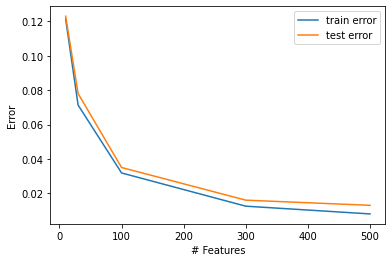

In [28]:
plt.plot(Features,Train_Error_storeLambda,label="train error")
plt.plot(Features,Test_Error_storeLambda,label="test error")
plt.legend(loc="upper right")
plt.xlabel('# Features')
plt.ylabel('Error')

In [29]:
from tabulate import tabulate

In [30]:
headers = ['# of Features','Lambda', 'Training Error','Test Error']   
table = zip(Features,Lambda_store,Train_Error_storeLambda,Test_Error_storeLambda)
print(tabulate(table, headers=headers))

  # of Features    Lambda    Training Error    Test Error
---------------  --------  ----------------  ------------
             10    0.19           0.121333          0.123
             30    0.133          0.0713333         0.078
            100    0.0875         0.0318333         0.035
            300    0.053          0.0125            0.016
            500    0.0386         0.008             0.013


In [31]:
###ROC###

In [32]:
train_fp, train_tp, _ = roc_curve(Gisette_train_Y, Pred_train_prob_storeLambda[3])
test_fp, test_tp, _ = roc_curve(Gisette_test_Y, Pred_test_prob_storeLambda[3])

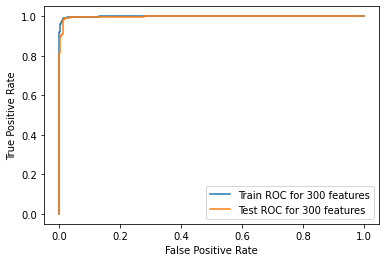

In [33]:
plt.plot(train_fp, train_tp, label='Train ROC for 300 features')
plt.plot(test_fp, test_tp, label='Test ROC for 300 features')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()